In [1]:
# Imports cell
from random import randint, seed
from dotenv import load_dotenv
import sys, pickle, shutil, os.path
from tud_sumo.simulation import Simulation
from tud_sumo.plot import Plotter, MultiPlotter
from datetime import datetime
import pandas as pd
from lxml import etree


# CT3505-24 - Traffic Flows and Management - 2025/26

## Assignment 2: Circular road network with Ramp Metering

## Using this interactive notebook
**Please refer to the course's Brightspace page. Find more information on this notebook in the README.md and INSTALL.md files.**

- Choose your vehicle and simulation parameters on the controls pane (<-)
- Click on (re-)Run simulation to let the notebook interact with the simulation backend (SUMO)
- Results are visualised below, under "Simulation results"
- If "Compare with previous simulation" is active when selecting "(re)-Run simulation", the latest simulation results will be kept and comparative KPIs will be shown for both that and the newly adapted inputs.
- If "Store simulation results" is selected, simulation results willbe stored in the *./experiments* folder. Simulation results are stored in pickled Pandas dataframes. Results can therefore be inspected manually through Pandas, other than through this notebook.
- If "Show simulation" is selected, SUMO's graphical user interface will open when a simulation is executed.

In [2]:
# Convenience functions
import re
def readSimDescription(filename=""):
    description=""
    if filename != "" and filename.split('.')[-1]=='txt' and os.path.exists(filename): #some nice checking that this is a text file with desired outputs
        raw_data=""
        with open(filename,'r') as f:
            raw_data = f.read().replace('\n', '')
        try: #this bit is try catch'd, if it fails description remains = ""
            raw_data=raw_data.split("Description:")[1]
            raw_data=raw_data.split("*")[0]
            raw_data=re.sub('\s{2,}', ' ', raw_data)    
            raw_data=raw_data.replace('|',' ')
            description=raw_data
        except Exception:
            pass
                

    return description

In [ ]:
#Simulation backend
simComplete=False
savesDir="./experiments/"
cacheDir="./cache/"
old_sim = None
forceGUI=True #Set to True to always run with GUI, False to run headless unless -gui is in command line args

def runScenario(my_sim):

    # Start the simulation, defining the sumo config files. Add "-gui" to the command line to run with the GUI.
    my_sim.start("./Network/rm_circle.sumocfg", get_individual_vehicle_data=False, gui=("-gui" in sys.argv) or forceGUI,
                 seed=sim_seed, units="metric", suppress_pbar=True) # Units can either be metric (km,kmph)/imperial (mi,mph)/UK (km,mph). All data collected is in these units.
    
    my_sim.add_tracked_edges(["B999B1000","B999B1000.327"])

    my_sim.add_tracked_junctions({"ramp_meter":
                                {'meter_params':
                                    {'min_rate': 200,  # Minimum allowed metering rate
                                    'max_rate': 2000,  # Maximum allowed metering rate
                                    'init_rate': 1800, # Initial metering rate
                                    },
                                'flow_params':
                                    {'inflow_detectors': ["ramp_inflow", "ramp_upstream"],
                                    'outflow_detectors': ["ramp_downstream"]}
                                }
                            })

    n, sim_dur, warmup = 1, 25*60 / my_sim.step_length, 0 / my_sim.step_length
    
   
    if warmup > 0:
        my_sim.step_through(n_steps=warmup, pbar_max_steps=sim_dur+warmup, keep_data=False)
    
    my_sim.set_tl_metering_rate(rm_id="ramp_meter", metering_rate=300)

    while my_sim.curr_step < sim_dur + warmup and my_sim.is_running():

        
        
        # Step through n seconds.
        my_sim.step_through(n_seconds=n, pbar_max_steps=sim_dur+warmup)
       



    # End the simulation.
    my_sim.end()


scenario_name="circle_"+datetime.now().strftime("%Y-%m-%d %H:%M:%S")
scenario_savefile=savesDir+"circle_"+datetime.now().strftime("%Y-%m-%d %H:%M:%S")




if not simComplete:
    print(f'Simulating scenario...')
    # Initialise the simulation object.
    scenario_desc = f"Circular roadway with Ramp Metering. "+datetime.now().strftime("%Y-%m-%d %H:%M:%S") #Procedurally generated scenario description for later readability
    my_sim = Simulation(scenario_name, scenario_desc=scenario_desc)
    # Add "-seed {x}" to the command line to set a seed for the simulation
    sim_seed = "1" if "-seed" not in sys.argv[:-1] else sys.argv[sys.argv.index("-seed")+1]
    seed(int(sim_seed))
    try:
        runScenario(my_sim)
    except Exception as e:
        print("Scenario computation failed. Error detail:", e)
        pass #Simply discard this simulation
    
    simComplete=True
    
        
    

Simulating scenario...
 Retrying in 1 seconds


# Simulation results

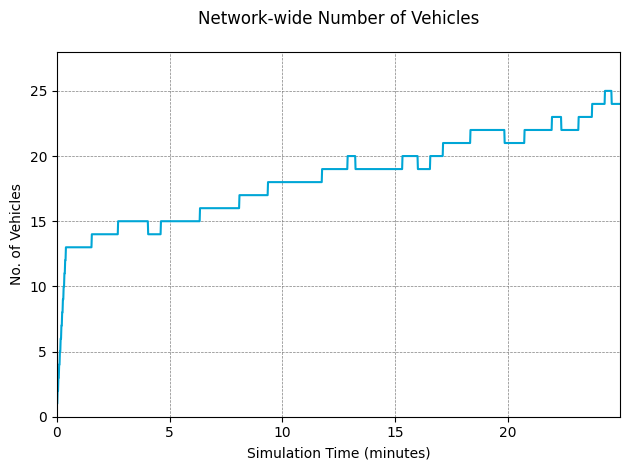

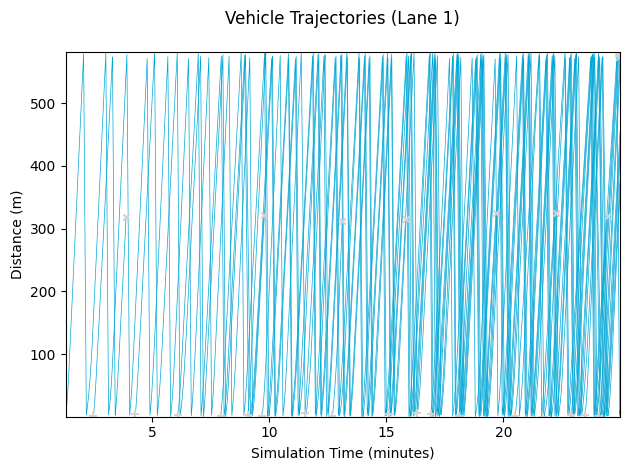

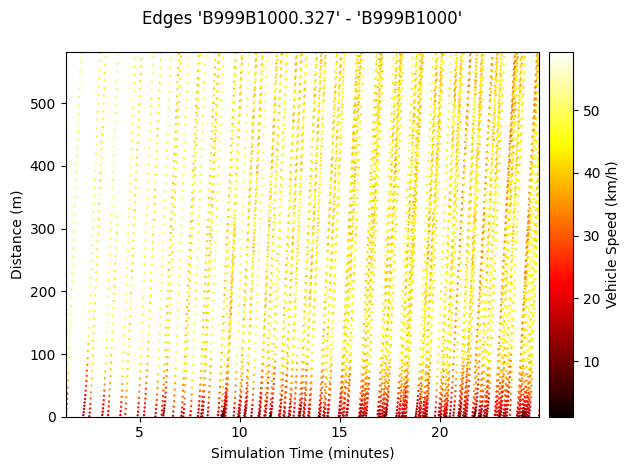

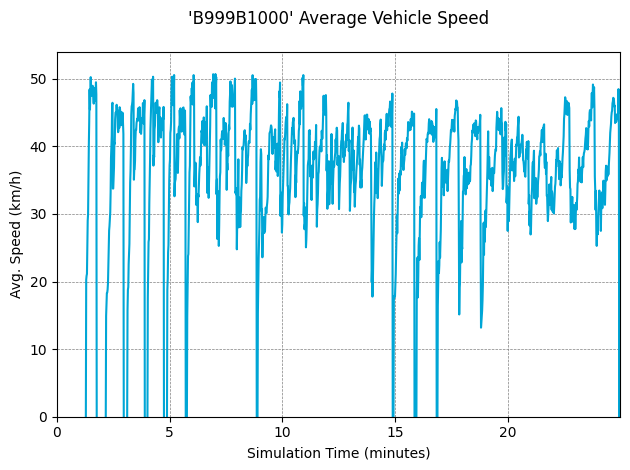

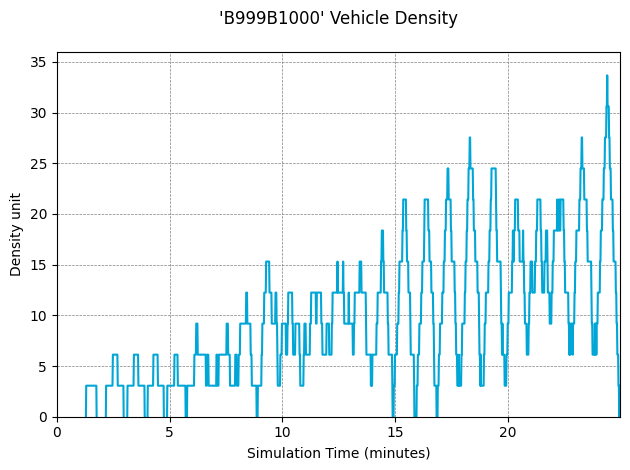

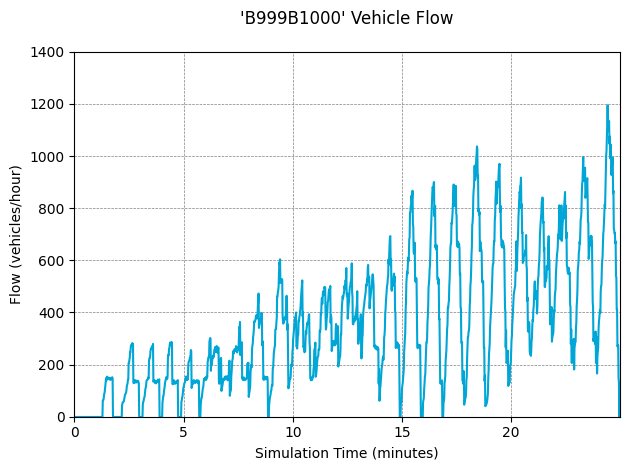

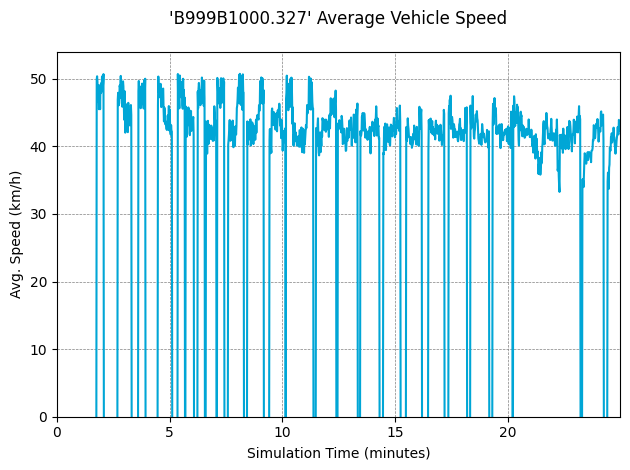

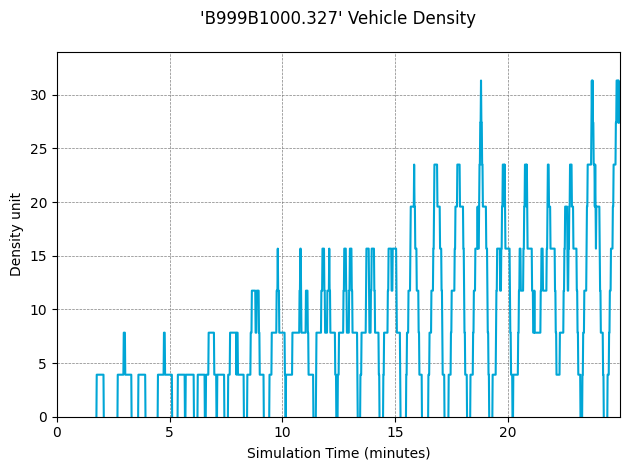

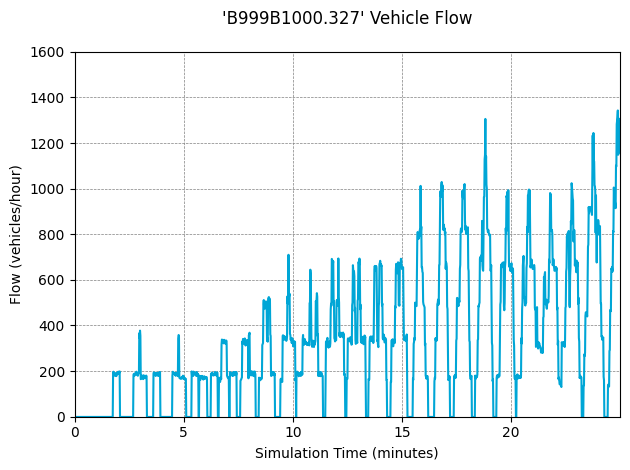

In [4]:
# Visualisation cells: show relevant sim results directly from my_sim object
trackedEdges=["B999B1000","B999B1000.327"] 

if simComplete:
    plt = Plotter(my_sim,time_unit="minutes")
    plt.plot_vehicle_data("no_vehicles")
    plt.plot_trajectories(trackedEdges, lane_idx=0)
    plt.plot_space_time_diagram(trackedEdges)
    for edge in trackedEdges:
        plt.plot_edge_data(edge,"speeds")
        plt.plot_edge_data(edge,"densities")
        plt.plot_edge_data(edge,"flows")